# Sentiment analysis

Generate sentiment class given text.

In [ ]:
CUDA_LAUNCH_BLOCKING="1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.2MB/s 
     |████████████████████████████████| 901kB 48.5MB/s 
     |████████████████████████████████| 3.3MB 53.2MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
import time

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/content/test.csv")
df

,ID,Label,Tweet,Date
0,264238274963451904,positive,"atlantic city, ventnor, margate, ocean city ar...",NaN
1,218775148495515649,positive,musical awareness: great big beautiful tomorro...,NaN
2,258965201766998017,neutral,on radio786 100.4fm 7:10 fri oct 19 labour ana...,NaN
3,262926411352903682,negative,"kapan sih lo ngebuktiin,jan ngomong doang susa...",NaN
4,171874368908050432,neutral,"excuse connectivity live stream, baba amr, man...",NaN
...,...,...,...,...
28417,681877834982232064,neutral,"i think asking, order. future, drake, thug, co...",NaN
28418,681879579129200640,positive,"iran ranks 1st liver surgeries, allah bless co...",NaN
28419,681883903259357184,neutral,"hours arrived saudi arabia tuesday, turkish pr...",NaN
28420,681904976860327936,negative,alex kim kardashian worth love kim kardashian ...,NaN


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/cheng-caver-lee-2-processed.csv", parse_dates=[3])
df2

,UserID,TweetID,Tweet,CreatedAt
0,5778702,52595012,going to bed now.,2007-05-06 21:00:00
1,5778702,53238082,up and @ them now. tTime to get to work.,2007-05-07 08:00:00
2,5778702,53636102,@ post office in line!!,2007-05-07 14:00:00
3,5778702,53842972,@ restaurant for dinner. Wings and salad time...,2007-05-07 17:00:00
4,774745,116236642,Twitter is back. Question: Anyone have concer...,2007-06-22 14:00:00
...,...,...,...,...
5093963,26962064,10618517948,"@user when I pointless text you, you pointless...",2010-03-17 07:00:00
5093964,56681877,10617161574,@user read a book! Hey Niecey!!!,2010-03-17 07:00:00
5093965,15342502,10617707268,"Bout to nap it up, please DND.",2010-03-17 07:00:00
5093966,18782786,10618404437,"@user thanks for yet another insightful post, ...",2010-03-17 07:00:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094510 entries, 0 to 5094509
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   UserID     int64         
 1   TweetID    int64         
 2   Tweet      object        
 3   CreatedAt  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 155.5+ MB


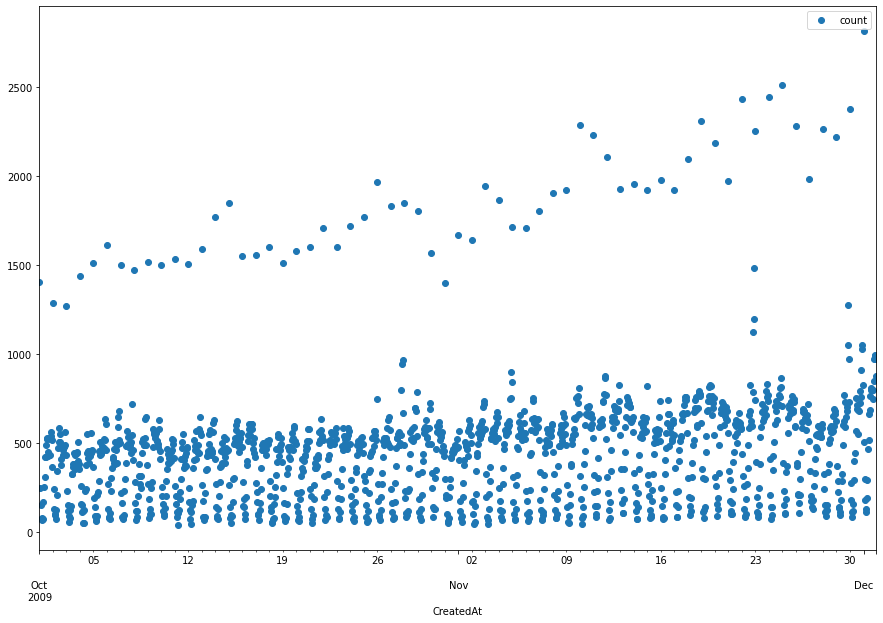

In [ ]:
df.groupby("CreatedAt").Tweet.agg(['count'])["2009-10-01":"2009-12-01"].plot(figsize=(15,10), style='o')

In [ ]:
classifier = transformers.pipeline("sentiment-analysis", device = 0, 
                                   model="cardiffnlp/twitter-roberta-base-sentiment",
                                   binary_output=True)

In [ ]:
import time
from IPython.display import clear_output

In [ ]:
def get_pred(text, length, batch_size=100,
             sent_dict={"LABEL_0":-1, "LABEL_1":0, "LABEL_2":1}):
    
    res = np.zeros((length,2))
    res[:] = np.nan
    cur_row = 0
    loading = 0

    t_start = time.process_time_ns()
    print(f"Row: {cur_row}. Progress: {loading}/100")
    for row in range(0,length,batch_size):
        # try:
            output = classifier(list(text[row:min(length,row+batch_size)]))
            for i,elem in enumerate(output):
                senti = sent_dict[elem["label"]]
                score = elem["score"]

                cur_row = row + i
                res[cur_row] = [senti, score]

            if round(cur_row/length*100,0) > loading:

                loading = round(cur_row/length*100,0)
                t_stop = time.process_time_ns()
                elapsed_time = t_stop - t_start
                time_left = ((100-loading) * elapsed_time)*1e-9
                mins = round(time_left/60, 0)
                secs = round(time_left%60, 0)

                
                print(f"Row: {cur_row}. Progress: {loading}/100. Time left: {mins} mins {secs} secs")
                # clear_output(wait=True)
                t_start = time.process_time_ns()


        # except Exception as e:
        #     print(f"Error on row {cur_row}: {e}")
        #     break

    print("Processing complete!")
    return res

In [ ]:
import random

In [ ]:
def test_pred(text, length, batch_size):

    pred = get_pred(text, length, batch_size)

    a = random.randint(0,length)
    assert round(classifier(text[a])[0]['score'],2) == round(pred[a,1],2), f"Failed on index {a}"

    a = random.randint(0,length)
    assert round(classifier(text[a])[0]['score'],2) == round(pred[a,1],2), f"Failed on index {a}"
    
    a = 0
    assert round(classifier(text[a])[0]['score'],2) == round(pred[a,1],2), f"Failed on index {a}"

    a = length-1
    assert round(classifier(text[a])[0]['score'],2) == round(pred[a,1],2), f"Failed on index {a}"

    a = max(0, length-2)
    assert round(classifier(text[a])[0]['score'],2) == round(pred[a,1],2), f"Failed on index {a}"

    print("Test succeeded!")
    

In [ ]:
pred[a,1]

0.5730621814727783

In [ ]:
classifier(text[a])[0]['score']

0.5145149230957031

In [ ]:
a

16265

In [ ]:
text = df.Tweet
pred = get_pred(df.Tweet,97594,100)

length = 97594
a = max(0, length-1)
assert round(classifier(text[a])[0]['score'],2) == round(pred[a,1],2), f"Failed on index {a}"

Row: 0. Progress: 0/100
Row: 499. Progress: 1.0/100. Time left: 1.0 mins 10.0 secs
Row: 1499. Progress: 2.0/100. Time left: 2.0 mins 10.0 secs
Row: 2499. Progress: 3.0/100. Time left: 2.0 mins 4.0 secs
Row: 3499. Progress: 4.0/100. Time left: 2.0 mins 6.0 secs
Row: 4399. Progress: 5.0/100. Time left: 2.0 mins 52.0 secs
Row: 5399. Progress: 6.0/100. Time left: 2.0 mins 6.0 secs
Row: 6399. Progress: 7.0/100. Time left: 2.0 mins 2.0 secs
Row: 7399. Progress: 8.0/100. Time left: 2.0 mins 1.0 secs
Row: 8299. Progress: 9.0/100. Time left: 2.0 mins 43.0 secs
Row: 9299. Progress: 10.0/100. Time left: 2.0 mins 3.0 secs
Row: 10299. Progress: 11.0/100. Time left: 2.0 mins 54.0 secs
Row: 11299. Progress: 12.0/100. Time left: 2.0 mins 57.0 secs
Row: 12299. Progress: 13.0/100. Time left: 2.0 mins 54.0 secs
Row: 13199. Progress: 14.0/100. Time left: 2.0 mins 42.0 secs
Row: 14199. Progress: 15.0/100. Time left: 2.0 mins 50.0 secs
Row: 15199. Progress: 16.0/100. Time left: 2.0 mins 52.0 secs
Row: 16199

IndexError: ignored

In [ ]:
df2.shape

(5093968, 4)

In [ ]:
test_pred(df.Tweet,len(df),100)

Row: 0. Progress: 0/100
Row: 199. Progress: 1.0/100. Time left: 1.0 mins 30.0 secs
Row: 499. Progress: 2.0/100. Time left: 1.0 mins 37.0 secs
Row: 799. Progress: 3.0/100. Time left: 1.0 mins 41.0 secs
Row: 999. Progress: 4.0/100. Time left: 0.0 mins 24.0 secs
Row: 1299. Progress: 5.0/100. Time left: 1.0 mins 37.0 secs
Row: 1599. Progress: 6.0/100. Time left: 1.0 mins 36.0 secs
Row: 1899. Progress: 7.0/100. Time left: 1.0 mins 36.0 secs
Row: 2199. Progress: 8.0/100. Time left: 1.0 mins 34.0 secs
Row: 2499. Progress: 9.0/100. Time left: 1.0 mins 35.0 secs
Row: 2799. Progress: 10.0/100. Time left: 1.0 mins 35.0 secs
Row: 2999. Progress: 11.0/100. Time left: 0.0 mins 24.0 secs
Row: 3299. Progress: 12.0/100. Time left: 1.0 mins 34.0 secs
Row: 3599. Progress: 13.0/100. Time left: 1.0 mins 35.0 secs
Row: 3899. Progress: 14.0/100. Time left: 1.0 mins 34.0 secs
Row: 4199. Progress: 15.0/100. Time left: 1.0 mins 32.0 secs
Row: 4499. Progress: 16.0/100. Time left: 1.0 mins 36.0 secs
Row: 4699. Pr

*** PROCESS ***
noice


In [ ]:
res = get_pred(df.Tweet,len(df.Tweet),100)
res

Row: 0. Progress: 0/100
Row: 199. Progress: 1.0/100. Time left: 1.0 mins 31.0 secs
Row: 499. Progress: 2.0/100. Time left: 1.0 mins 38.0 secs
Row: 799. Progress: 3.0/100. Time left: 1.0 mins 41.0 secs
Row: 999. Progress: 4.0/100. Time left: 0.0 mins 25.0 secs
Row: 1299. Progress: 5.0/100. Time left: 1.0 mins 37.0 secs
Row: 1599. Progress: 6.0/100. Time left: 1.0 mins 36.0 secs
Row: 1899. Progress: 7.0/100. Time left: 1.0 mins 37.0 secs
Row: 2199. Progress: 8.0/100. Time left: 1.0 mins 35.0 secs
Row: 2499. Progress: 9.0/100. Time left: 1.0 mins 34.0 secs
Row: 2799. Progress: 10.0/100. Time left: 1.0 mins 35.0 secs
Row: 2999. Progress: 11.0/100. Time left: 0.0 mins 23.0 secs
Row: 3299. Progress: 12.0/100. Time left: 1.0 mins 34.0 secs
Row: 3599. Progress: 13.0/100. Time left: 1.0 mins 35.0 secs
Row: 3899. Progress: 14.0/100. Time left: 1.0 mins 34.0 secs
Row: 4199. Progress: 15.0/100. Time left: 1.0 mins 32.0 secs
Row: 4499. Progress: 16.0/100. Time left: 1.0 mins 36.0 secs
Row: 4699. Pr

array([[1.        , 0.59207994],
       [1.        , 0.79808474],
       [0.        , 0.89176416],
       ...,
       [0.        , 0.61208451],
       [0.        , 0.649234  ],
       [0.        , 0.70035452]])

In [ ]:
 df_res = pd.DataFrame(res, columns=["Sentiment","Score"])
 df_res

,Sentiment,Score
0,1.0,0.592080
1,1.0,0.798085
2,0.0,0.891764
3,0.0,0.685669
4,0.0,0.567415
...,...,...
28417,0.0,0.890386
28418,1.0,0.502652
28419,0.0,0.612085
28420,0.0,0.649234


In [ ]:
y[:100]

array([ 1,  1,  0, -1,  0,  1,  0,  1,  1,  0,  1,  0, -1,  1, -1,  1, -1,
        1,  1,  1,  1,  0,  1,  1,  0,  1,  1, -1,  1,  1,  0, -1,  1, -1,
        0,  0,  0, -1,  1,  0,  1, -1,  0, -1, -1,  0,  0,  0, -1, -1,  0,
       -1,  1,  0,  1,  1, -1,  1,  0,  0,  1,  1,  0,  1,  1,  1,  1, -1,
        1,  1,  0,  1,  0,  0,  1,  1,  1, -1,  0, -1, -1,  0,  1,  1,  0,
        1,  0,  0,  0,  1,  1,  1,  1,  0,  1,  0,  1,  1,  1,  0])

In [ ]:
y_hat[:100]

array([ 1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
        0., -1.,  1., -1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
        1., -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  1.,
        0.,  1., -1.,  0.,  0., -1.,  0.,  0.,  1., -1., -1.,  0., -1.,
        0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  0., -1.,  0.,  0.,  1.,  1.,  1.,  0.,
        0., -1.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  1., -1.,  1.,  0.,
        1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.])

In [ ]:
y_hat = df_res.Sentiment.values
y_hat

array([1., 1., 0., ..., 0., 0., 0.])

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sn

In [ ]:
def evaluate(y_pred, y_true):

    # Get accuracy over the test set
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    #Get confusion matrix
    conf=confusion_matrix(y_true, y_pred)
    print("Confusion matrix")#, conf)
    df_cm = pd.DataFrame(conf, [-1,0,1],[-1,0,1])
    sn.set(font_scale=1.4)#for label size
    group_counts = ["{0:0.0f}".format(value) for value in conf.flatten()]
    labels = [f"{v1}" for v1 in (group_counts)]
    labels = np.asarray(labels).reshape(3,3)
    sn.heatmap(df_cm, annot=labels,fmt='',cmap=plt.cm.Blues)# font size

In [ ]:
(y_hat == y).mean()

0.7492435437337274

Accuracy: 74.92%
Confusion matrix


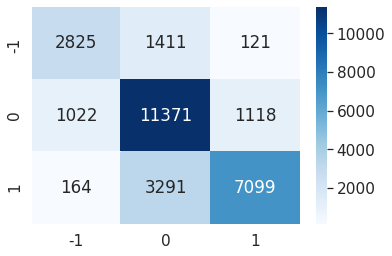

In [ ]:
evaluate(y_hat,y)

In [ ]:
y = df.Label.replace(to_replace={"positive":1, "neutral":0, "negative":-1}).values
y

array([ 1,  1,  0, ...,  0, -1,  0])

In [ ]:
df2 = pd.concat([df,df_res], axis=1)
df2

,ID,Label,Tweet,Date,Sentiment,Score
0,264238274963451904,positive,"atlantic city, ventnor, margate, ocean city ar...",NaN,1.0,0.592080
1,218775148495515649,positive,musical awareness: great big beautiful tomorro...,NaN,1.0,0.798085
2,258965201766998017,neutral,on radio786 100.4fm 7:10 fri oct 19 labour ana...,NaN,0.0,0.891764
3,262926411352903682,negative,"kapan sih lo ngebuktiin,jan ngomong doang susa...",NaN,0.0,0.685669
4,171874368908050432,neutral,"excuse connectivity live stream, baba amr, man...",NaN,0.0,0.567415
...,...,...,...,...,...,...
28417,681877834982232064,neutral,"i think asking, order. future, drake, thug, co...",NaN,0.0,0.890386
28418,681879579129200640,positive,"iran ranks 1st liver surgeries, allah bless co...",NaN,1.0,0.502652
28419,681883903259357184,neutral,"hours arrived saudi arabia tuesday, turkish pr...",NaN,0.0,0.612085
28420,681904976860327936,negative,alex kim kardashian worth love kim kardashian ...,NaN,0.0,0.649234


In [ ]:
df2

,UserID,TweetID,Tweet,CreatedAt
0,5778702,52595012,going to bed now.,2007-05-06 21:00:00
1,5778702,53238082,up and @ them now. tTime to get to work.,2007-05-07 08:00:00
2,5778702,53636102,@ post office in line!!,2007-05-07 14:00:00
3,5778702,53842972,@ restaurant for dinner. Wings and salad time...,2007-05-07 17:00:00
4,774745,116236642,Twitter is back. Question: Anyone have concer...,2007-06-22 14:00:00
...,...,...,...,...
5093963,26962064,10618517948,"@user when I pointless text you, you pointless...",2010-03-17 07:00:00
5093964,56681877,10617161574,@user read a book! Hey Niecey!!!,2010-03-17 07:00:00
5093965,15342502,10617707268,"Bout to nap it up, please DND.",2010-03-17 07:00:00
5093966,18782786,10618404437,"@user thanks for yet another insightful post, ...",2010-03-17 07:00:00


In [ ]:
df_res.iloc[5093423]

Sentiment    0.000000
Score        0.417653
Name: 5093423, dtype: float64

In [ ]:
df

In [ ]:
df1 = pd.concat([df2.iloc[:len(df_res)], df_res], axis=1)
df1

,UserID,TweetID,Tweet,CreatedAt,Sentiment,Score
0,5778702,52595012,going to bed now.,2007-05-06 21:00:00,0.0,0.705584
1,5778702,53238082,up and @ them now. tTime to get to work.,2007-05-07 08:00:00,0.0,0.638969
2,5778702,53636102,@ post office in line!!,2007-05-07 14:00:00,0.0,0.716893
3,5778702,53842972,@ restaurant for dinner. Wings and salad time...,2007-05-07 17:00:00,1.0,0.931264
4,774745,116236642,Twitter is back. Question: Anyone have concer...,2007-06-22 14:00:00,0.0,0.674463
...,...,...,...,...,...,...
5093421,52335257,10608239878,@user tmi lmao,2010-03-17 01:00:00,0.0,0.598157
5093422,15722681,10609185725,@user ok season 4 complete.. WOW! Kill me now,2010-03-17 01:00:00,-1.0,0.701659
5093423,52335257,10608120156,I just want my donuts and milk!,2010-03-17 01:00:00,0.0,0.417653
5093424,40592091,10609410167,#sexisbest wit a stranger,2010-03-17 01:00:00,1.0,0.527740


In [ ]:
df1.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP/cheng-caver-lee-2-tagged.csv", index=False)

In [ ]:
idx = 5333

classifier(df2.Tweet[idx])[0]["score"] == df1.Score[idx]

True

In [ ]:
df1.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP/cheng-caver-lee-2-tagged.csv.csv",
              index=False)

In [ ]:
df2 = pd.concat([df,df1], axis=0)
df2

,UserID,TweetID,Tweet,CreatedAt,Sentiment,Score
0,5622,28191,trying to figure out what this thing is.,2006-09-10 11:00:00,0.0,0.628504
1,38323,581203,Getting ready to go to the Improv Olympic to s...,2006-12-02 22:00:00,1.0,0.620787
2,690103,3873613,Customer support is no fun at all.,2007-01-23 18:00:00,-1.0,0.975901
3,690103,3882273,Is Luke a h8r?,2007-01-23 19:00:00,0.0,0.894001
4,690103,3880013,I am still doing customer support,2007-01-23 19:00:00,0.0,0.735228
...,...,...,...,...,...,...
5093421,52335257,10608239878,@user tmi lmao,2010-03-17 01:00:00,0.0,0.598157
5093422,15722681,10609185725,@user ok season 4 complete.. WOW! Kill me now,2010-03-17 01:00:00,-1.0,0.701659
5093423,52335257,10608120156,I just want my donuts and milk!,2010-03-17 01:00:00,0.0,0.417653
5093424,40592091,10609410167,#sexisbest wit a stranger,2010-03-17 01:00:00,1.0,0.527740


In [ ]:
df2.drop(df2.columns[0], axis=1,inplace=True)
df2

,Tweet,CreatedAt,Sentiment,Score
0,trying to figure out what this thing is.,2006-09-10 11:00:00,0.0,0.628504
1,Getting ready to go to the Improv Olympic to s...,2006-12-02 22:00:00,1.0,0.620787
2,Customer support is no fun at all.,2007-01-23 18:00:00,-1.0,0.975901
3,Is Luke a h8r?,2007-01-23 19:00:00,0.0,0.894001
4,I am still doing customer support,2007-01-23 19:00:00,0.0,0.735228
...,...,...,...,...
8753174,@user ok season 4 complete.. WOW! Kill me now,2010-03-17 01:00:00,-1.0,0.701659
8753175,I just want my donuts and milk!,2010-03-17 01:00:00,0.0,0.417653
8753176,I be damned if I give Fulton County another ce...,2010-03-17 01:00:00,-1.0,0.968688
8753177,#sexisbest when I ride it backwards so he can ...,2010-03-17 01:00:00,1.0,0.734608


In [ ]:
df2.to_csv("/content/drive/MyDrive/Colab Notebooks/NLP/cheng-caver-lee-final.csv", index=False)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8753179 entries, 0 to 5093425
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   UserID     int64         
 1   TweetID    int64         
 2   Tweet      object        
 3   CreatedAt  datetime64[ns]
 4   Sentiment  float64       
 5   Score      float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 467.5+ MB


In [ ]:
df_res = pd.concat([df,df_res], axis=1)
df_res

,UserID,TweetID,Tweet,CreatedAt,Sentiment,Score
0,5622,28191,trying to figure out what this thing is.,2006-09-10 11:00:00,0.0,0.628504
1,38323,581203,Getting ready to go to the Improv Olympic to s...,2006-12-02 22:00:00,1.0,0.620787
2,690103,3873613,Customer support is no fun at all.,2007-01-23 18:00:00,-1.0,0.975901
3,690103,3882273,Is Luke a h8r?,2007-01-23 19:00:00,0.0,0.894001
4,690103,3880013,I am still doing customer support,2007-01-23 19:00:00,0.0,0.735228
...,...,...,...,...,...,...
3659748,22307857,6485532854,"NYC at holiday time, can't go wrong. Ate with ...",2009-12-08 21:00:00,1.0,0.789063
3659749,34739186,6486831431,Stop tweeting while we're at dinner!!! ;) RT @...,2009-12-08 22:00:00,1.0,0.914769
3659750,22097952,6485873515,"@user hahaha. I mean, New York Style in LA is ...",2009-12-08 22:00:00,1.0,0.955433
3659751,34739186,6486280798,WOW! Cardio Barre was AMAZING-I had no idea u ...,2009-12-08 22:00:00,1.0,0.989414
